#**Universidad Galileo**
##Statistical Learning II - Proyecto Multilayer Perceptron
###César Luis Polanco
###20062088

# Predicción fumadores
<br>

## Contexto

En la línea de negocio de las aseguradoras, existe siempre el riesgo que la persona sea o no fumadora y por lo mismo sea propenso a tener una enfermedad terminal como el cancer, se busca predecir en base a caracteristicas como edad, genero, bmi. etc.

## Objetivo
Para esta parte del proyecto se estará realizando una predicción si la persona puede o no ser fumadora para identificar posibles riesgos futuros en la inversión de la aseguradora.

In [ ]:
#Cargar libreria
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn as sk
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.callbacks import ModelCheckpoint

In [ ]:
#Mount Gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir =  '/content/drive/MyDrive/SL2/MLP'
dir_data = '/content/drive/MyDrive/SL2/MLP/data'
dir_checkpoint = os.path.dirname('/content/drive/MyDrive/SL2/CNN/checkpoint')
os.chdir( dir)

In [ ]:
df = pd.read_csv(dir_data+'/insurance.csv')

In [ ]:
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
df.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


In [ ]:
df_len = len(df)
df.isna().sum() /df_len 

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
expenses    0.0
dtype: float64

In [ ]:
cat_col=['smoker','region','sex']
num_col=[i for i in df.columns if i not in cat_col]
num_col

['age', 'bmi', 'children', 'expenses']

In [ ]:
one_hot=pd.get_dummies(df[cat_col])
insur_procsd_df=pd.concat([df[num_col],one_hot],axis=1)
insur_procsd_df.head(10)

,age,bmi,children,expenses,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,sex_female,sex_male
0,19,27.9,0,16884.92,0,1,0,0,0,1,1,0
1,18,33.8,1,1725.55,1,0,0,0,1,0,0,1
2,28,33.0,3,4449.46,1,0,0,0,1,0,0,1
3,33,22.7,0,21984.47,1,0,0,1,0,0,0,1
4,32,28.9,0,3866.86,1,0,0,1,0,0,0,1
5,31,25.7,0,3756.62,1,0,0,0,1,0,1,0
6,46,33.4,1,8240.59,1,0,0,0,1,0,1,0
7,37,27.7,3,7281.51,1,0,0,1,0,0,1,0
8,37,29.8,2,6406.41,1,0,1,0,0,0,0,1
9,60,25.8,0,28923.14,1,0,0,1,0,0,1,0


In [ ]:
df_encoded=df
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for i in cat_col:
    df_encoded[i] = encoder.fit_transform(df_encoded[i])

In [ ]:
df_encoded.head(5)

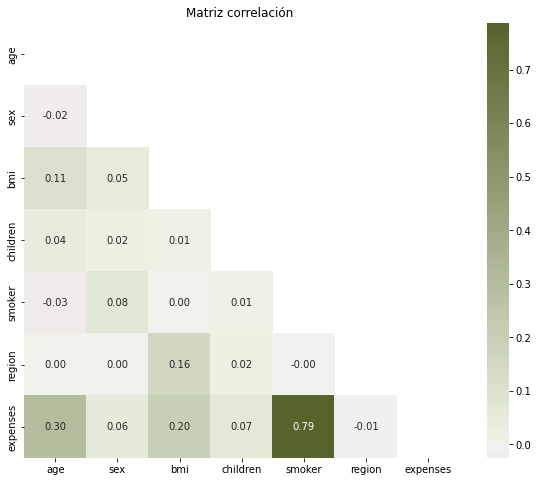

In [ ]:
corr = round(df_encoded.corr(), 4)
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(7, 100, s=75, l=40,n=5, center="light", as_cmap=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, center=0, annot=True,
            fmt='.2f', square=True, cmap=cmap)
plt.title("Matriz correlación ")
plt.show()

## Creación de datos de entrenamiento y pruebas

In [ ]:
x=df_encoded.drop(columns=['smoker'])
y=df[['smoker']]

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(x,y,test_size=0.3,shuffle=True)

## Escalar los datos

In [ ]:
scaler = StandardScaler()
train_x = pd.DataFrame(scaler.fit_transform(train_x), columns = train_x.columns)
test_x = pd.DataFrame(scaler.fit_transform(test_x), columns = test_x.columns)

## Checkpoint para callbacks

In [ ]:
checkpoint = ModelCheckpoint(filepath=dir_checkpoint,
                             monitor = 'val_accuracy',
                             verbose=1, 
                             save_best_onlya=True,)

## Crear modelo MLP

In [ ]:
model = Sequential([
        Dense(units=256, activation='relu', kernel_initializer='random_uniform'),
        Dropout(0.30),
        Dense(units=128, activation='relu', kernel_initializer='random_uniform'),
        Dropout(0.50),
        Dense(units=32, activation='relu', kernel_initializer='random_uniform'),
        Dropout(0.50),
        Dense(units=1, activation='sigmoid')
        ])

## Entrenar modelo

In [ ]:
loss = 'BinaryCrossentropy'
optimizer = 'Nadam'
lr = 0.00001

validation_split = 0.20
batch_size = 30
epochs = 200

model.compile(loss=loss,
              optimizer=eval('keras.optimizers.'+str(optimizer)+'(learning_rate='+str(lr)+')'),
              metrics='accuracy')

In [ ]:
history = model.fit(
    train_x,
    train_y,
    validation_split = validation_split,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [checkpoint]
)

Epoch 1/200
20/25 [=======================>......] - ETA: 0s - loss: 0.6947 - accuracy: 0.4100 
Epoch 1: saving model to /content/drive/MyDrive/SL2/CNN
25/25 [==============================] - 5s 93ms/step - loss: 0.6946 - accuracy: 0.4171 - val_loss: 0.6932 - val_accuracy: 0.4521
Epoch 2/200
20/25 [=======================>......] - ETA: 0s - loss: 0.6936 - accuracy: 0.4650
Epoch 2: saving model to /content/drive/MyDrive/SL2/CNN
25/25 [==============================] - 1s 48ms/step - loss: 0.6934 - accuracy: 0.4773 - val_loss: 0.6921 - val_accuracy: 0.7606
Epoch 3/200
17/25 [===================>..........] - ETA: 0s - loss: 0.6928 - accuracy: 0.5039
Epoch 3: saving model to /content/drive/MyDrive/SL2/CNN
25/25 [==============================] - 1s 46ms/step - loss: 0.6928 - accuracy: 0.5147 - val_loss: 0.6911 - val_accuracy: 0.8351
Epoch 4/200
19/25 [=====================>........] - ETA: 0s - loss: 0.6918 - accuracy: 0.5842
Epoch 4: saving model to /content/drive/MyDrive/SL2/CNN
25/25

## Guardar modelo

In [ ]:
model.save(dir+'MLP_Model')

## Cargar modelo

In [ ]:
model.load_weights(dir+'MLP_Model')

## Gráfica del modelo

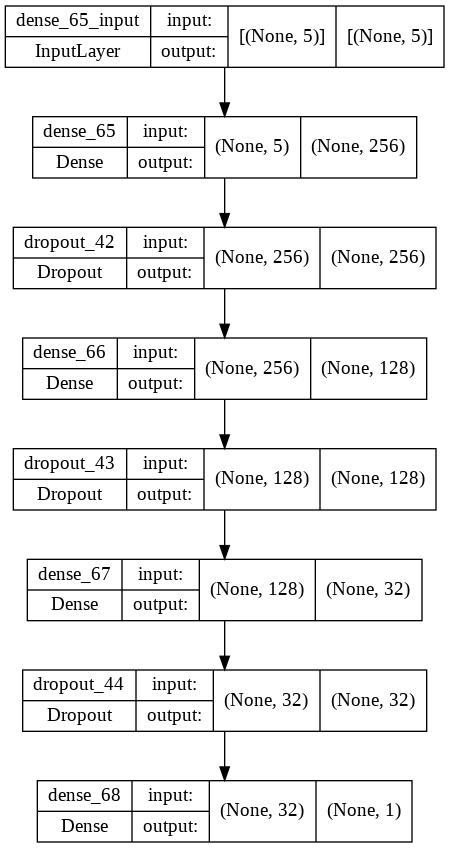

In [ ]:
tf.keras.utils.plot_model(model, to_file="MLP_Model.jpg", show_shapes=True)

## Primera ejecución MLP

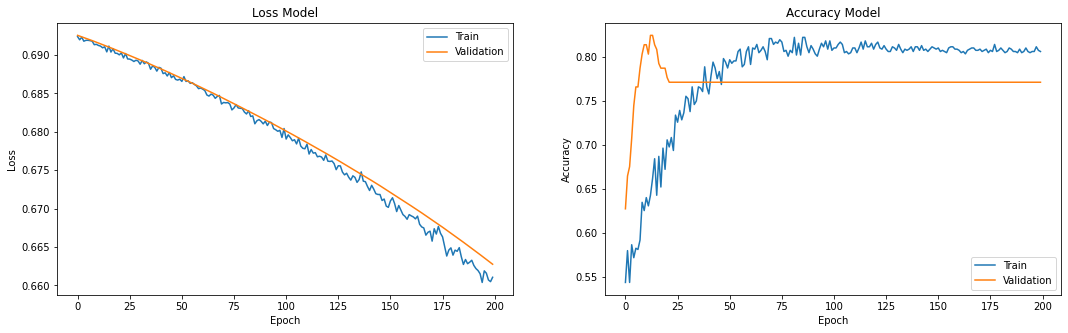

In [ ]:
plt.figure(figsize=(18, 5))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Segunda ejecución (sin mejoría)

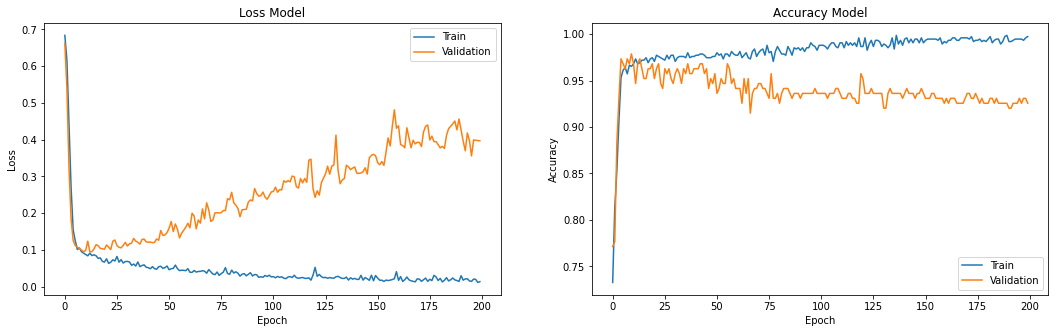

In [ ]:
plt.figure(figsize=(18, 5))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Tercera ejecución (Mejor modelo)

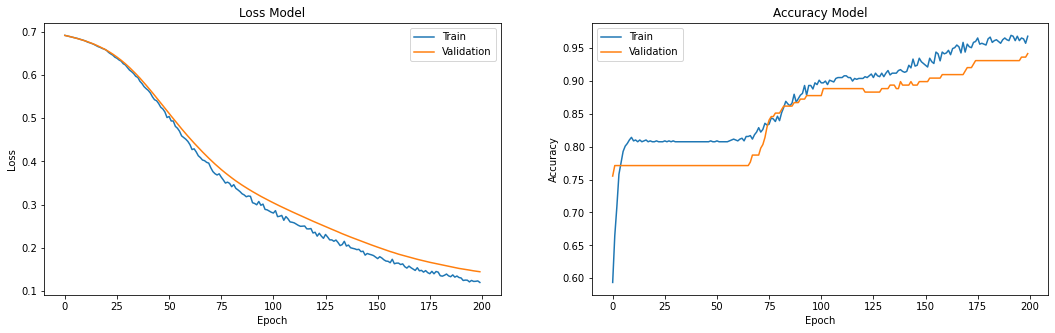

In [ ]:
plt.figure(figsize=(18, 5))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# Función para generar métricas de evaluación del modelo: Accuracy, Precision, Recall, F1

def metrics(x, y, model, scores_table):
  y_pred = model.predict(x)

  for i in range(len(y_pred)):
    if y_pred[i] > 0.5:
      y_pred[i] = 1
    else:
      y_pred[i] = 0

  model = len(os.listdir(dir_checkpoint)) + 1

  accuracy = sk.metrics.accuracy_score(y_true = y, y_pred = y_pred)
  precision = sk.metrics.precision_score(y_true = y, y_pred = y_pred)
  
  scores_table.loc[model] = [model, accuracy]

  return scores_table

In [ ]:
scores_table = pd.DataFrame(columns = ['Model', 'Accuracy'])
scores_table = metrics(test_x, test_y, model, scores_table)
scores_table

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Accuracy
13,13.0,0.800995


In [ ]:
scores_table = pd.DataFrame(columns = ['Model', 'Accuracy'])
scores_table = metrics(test_x, test_y, model, scores_table)
scores_table

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Accuracy
13,13.0,0.768657


In [ ]:
scores_table = pd.DataFrame(columns = ['Model', 'Accuracy'])
scores_table = metrics(test_x, test_y, model, scores_table)
scores_table

,Model,Accuracy
13,13.0,0.945274


## Conclusiones finales 


* Durante el entramiento se puede observar que los algoritmos pueden converger muy rápido o bien tomarse un tiempo todo dependerá de los parámetros y la forma cómo se creean los modelos. 

* Para este proyecto, se logró tener una precisión del 94% lo cual es un algoritmo bastante ajustado.

* Como lecciones aprendidas, es importante profundizar más sobre los métoods de activación y cómo funcionan los optimizadores ya que son parámetros que tambien pueden influir en los modelos.